## Setting up the dataset

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import wandb

In [52]:
"""
Loading both abnormal and normal datasets.
"""

normal_df = pd.read_csv("dataset/ptbdb_normal.csv").iloc[:, :-1]
abnormal_df = pd.read_csv(
    "dataset/ptbdb_abnormal.csv").iloc[:, :-1]

In [53]:
"""
To fix the imbalance, Trimming the abnormal set
"""

anomaly_df = abnormal_df.sample(n=2000, random_state=42)

In [54]:
"""
Dataset converted to numpy
"""
normal = normal_df.to_numpy()
anomaly = anomaly_df.to_numpy()

In [55]:
"""
Dataset split
"""

X_train, X_test = train_test_split(normal, test_size=0.15, random_state=42, shuffle=True)

In [56]:
"""
Custom dataset class for ECG Data
"""

class ECGDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]  # AutoEncoder


In [57]:
"""
Setting up dataloaders
"""

train_loader = DataLoader(ECGDataset(X_train), batch_size=128, shuffle=True)
test_loader = DataLoader(ECGDataset(X_test), batch_size=128)
anomaly_loader = DataLoader(ECGDataset(anomaly), batch_size=128)

In [58]:
"""
Defining the AutoEnoder model.
including both encoder and decoder
"""


class Conv1DAutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super(Conv1DAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(2),
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(2),
            nn.Conv1d(128, latent_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(latent_dim),
            nn.MaxPool1d(2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(latent_dim, latent_dim,
                               kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(latent_dim),
            nn.ConvTranspose1d(latent_dim, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.ConvTranspose1d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Flatten(),
            nn.Linear((input_dim//8)*128, input_dim)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

#DeviceSetup

In [59]:


if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


print(device)

mps


In [60]:

input_dim = X_train.shape[1]
model = Conv1DAutoEncoder(input_dim).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [61]:
# 7. INIT WAND B
wandb.init(project="ecg-anomaly-detection", name="drive-conv1d-autoencoder")

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


train_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,0.01663


Training

In [62]:
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch_X, _ in loop:
        batch_X = batch_X.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_X)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_X.size(0)
        loop.set_postfix(loss=loss.item())
    epoch_loss = running_loss / len(train_loader.dataset)
    wandb.log({"train_loss": epoch_loss})

Epoch 50/50: 100%|██████████| 27/27 [00:00<00:00, 68.74it/s, loss=0.0185]


In [63]:
"""
Defining loss computations
"""

def compute_losses(model, loader):
    model.eval()
    losses = []
    with torch.no_grad():
        for batch_X, _ in loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            loss = torch.mean(torch.abs(outputs - batch_X), dim=1)
            losses.extend(loss.cpu().numpy())
    return np.array(losses)

In [64]:
"""
Setting up the losses
"""

train_losses = compute_losses(model, train_loader)
test_losses = compute_losses(model, test_loader)
anomaly_losses = compute_losses(model, anomaly_loader)

In [65]:
"""
Setting up threshold
"""
threshold = np.mean(train_losses) + np.std(train_losses)

In [66]:
y_true = np.concatenate(
    [np.ones(len(train_losses) + len(test_losses)), np.zeros(len(anomaly_losses))])
y_pred = np.concatenate([(train_losses <= threshold).astype(int),
                         (test_losses <= threshold).astype(int),
                         (anomaly_losses <= threshold).astype(int)])

In [67]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

In [68]:
wandb.log({
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "roc_auc": auc
})

accuracy,▁
f1_score,▁
precision,▁
recall,▁
roc_auc,▁
train_loss,█▃▃▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.77998
f1_score,0.8572
precision,0.75764
recall,0.9869
roc_auc,0.6742


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


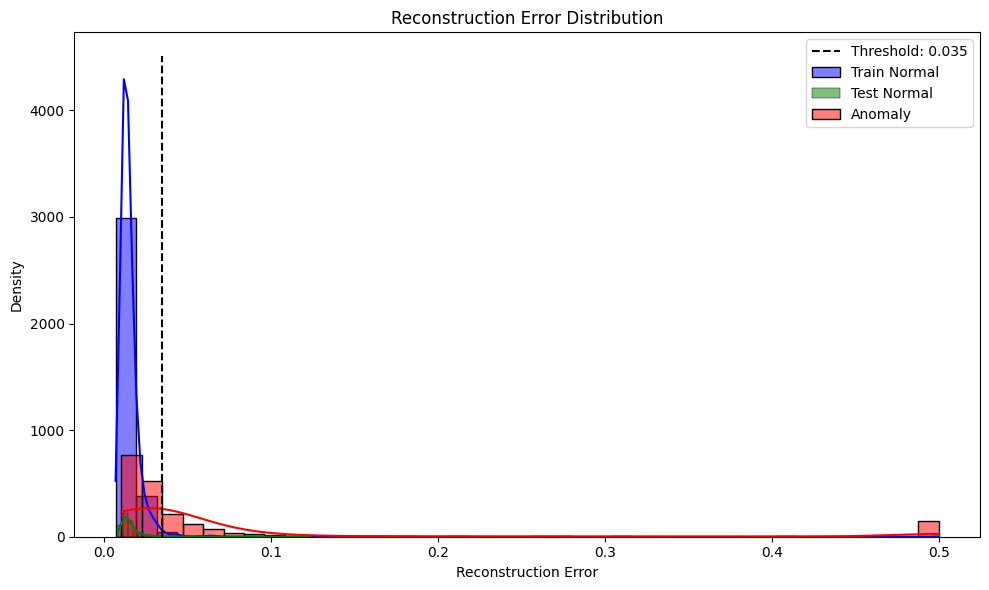

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


In [69]:
#Initialize WandB
wandb.init(project="ecg-anomaly-detection",
           name="reconstruction-error-plot", reinit=True)


# Function for prediciton
def predict(model, data):
    model.eval()
    data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
    with torch.no_grad():
        reconstructed = model(data_tensor)
    # Reconstruction error (MAE per sample)
    loss = torch.mean(torch.abs(reconstructed - data_tensor),
                      dim=1).cpu().numpy()
    return reconstructed.cpu().numpy(), loss


# Loss computation
_, train_loss = predict(model, X_train)
_, test_loss = predict(model, X_test)
_, anomaly_loss = predict(model, anomaly)

# Threshold
threshold = np.mean(train_loss) + np.std(train_loss)

#Visualizing the reconstruction error
bins = 40
plt.figure(figsize=(10, 6))

# Train normal distribution
sns.histplot(np.clip(train_loss, 0, 0.5), bins=bins,
             kde=True, label="Train Normal", color="blue")

# Test normal distribution
sns.histplot(np.clip(test_loss, 0, 0.5), bins=bins,
             kde=True, label="Test Normal", color="green")

# Anomaly distribution
sns.histplot(np.clip(anomaly_loss, 0, 0.5), bins=bins,
             kde=True, label="Anomaly", color="red")

# Plot threshold line
ax = plt.gca()
ylim = ax.get_ylim()
plt.vlines(threshold, 0, ylim[1], color="black",
           linestyle="--", label=f"Threshold: {threshold:.3f}")

# Labels & legend
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.title("Reconstruction Error Distribution")
plt.legend()
plt.tight_layout()

wandb.log({"reconstruction_error_distribution": wandb.Image(plt)})

plt.show()
plt.close()
wandb.finish()

Error: You must call wandb.init() before wandb.log()

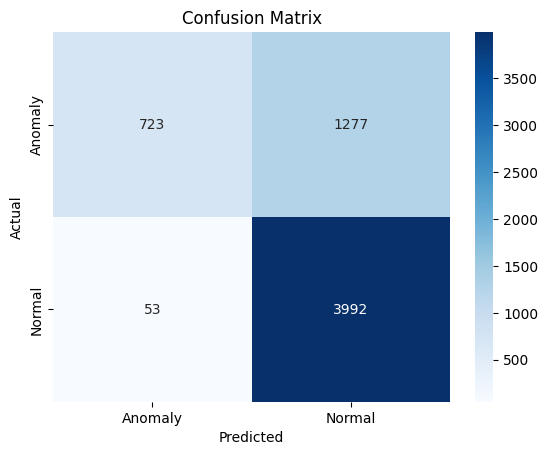

In [70]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[
            "Anomaly", "Normal"], yticklabels=["Anomaly", "Normal"])
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.title("Confusion Matrix")
wandb.log({"confusion_matrix": wandb.Image(fig)})
plt.close()

Error: You must call wandb.init() before wandb.log()

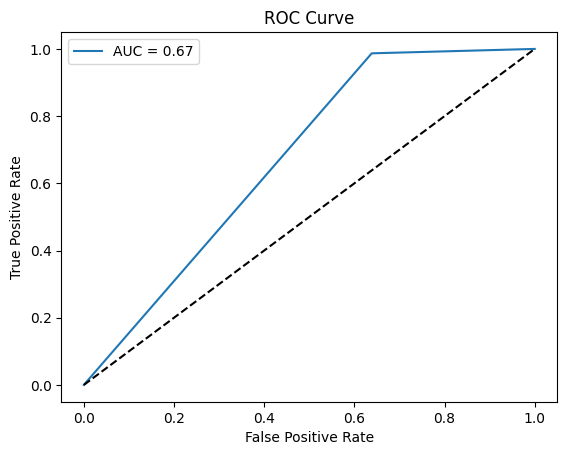

In [71]:
"""
Setting up ROC Curve
"""
fpr, tpr, _ = roc_curve(y_true, y_pred)
fig, ax = plt.subplots()
ax.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve")
ax.legend()
wandb.log({"roc_curve": wandb.Image(fig)})
plt.close()

wandb.finish()

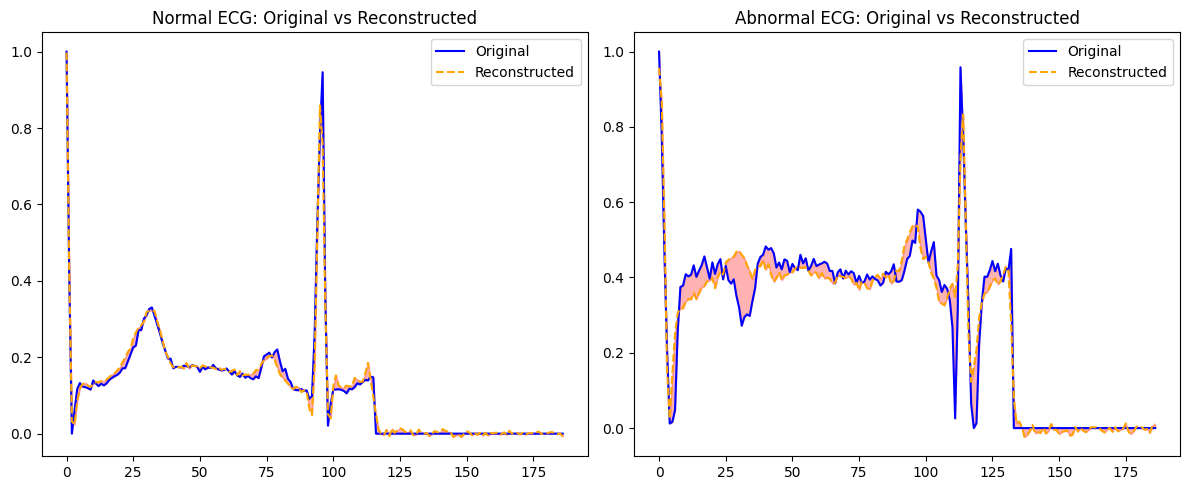

In [72]:
"""
Visualizing the normal and abnormal signals
"""


# Select normal and abnormal samples for visualization
normal_idx = np.random.randint(0, len(X_test))
abnormal_idx = np.random.randint(0, len(anomaly))

normal_sample = torch.tensor(
    X_test[normal_idx], dtype=torch.float32).unsqueeze(0).to(device)
abnormal_sample = torch.tensor(
    anomaly[abnormal_idx], dtype=torch.float32).unsqueeze(0).to(device)

# Prediction of reconstruction


def predict_sample(model, sample):
    model.eval()
    with torch.no_grad():
        reconstruction = model(sample)
    return reconstruction


# reconstructed outputs
normal_recon = predict_sample(model, normal_sample)
abnormal_recon = predict_sample(model, abnormal_sample)

# signals for plotting
normal_signal = normal_sample.squeeze().detach().cpu().numpy()
normal_reconstructed = normal_recon.squeeze().detach().cpu().numpy()
abnormal_signal = abnormal_sample.squeeze().detach().cpu().numpy()
abnormal_reconstructed = abnormal_recon.squeeze().detach().cpu().numpy()

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Normal ECG: Original vs Reconstructed
axs[0].plot(normal_signal, label='Original', color='blue')
axs[0].plot(normal_reconstructed, label='Reconstructed',
            linestyle='--', color='orange')
axs[0].fill_between(range(len(normal_signal)), normal_signal,
                    normal_reconstructed, alpha=0.3, color='red')
axs[0].set_title("Normal ECG: Original vs Reconstructed")
axs[0].legend()

# Abnormal ECG: Original vs Reconstructed
axs[1].plot(abnormal_signal, label='Original', color='blue')
axs[1].plot(abnormal_reconstructed, label='Reconstructed',
            linestyle='--', color='orange')
axs[1].fill_between(range(len(abnormal_signal)), abnormal_signal,
                    abnormal_reconstructed, alpha=0.3, color='red')
axs[1].set_title("Abnormal ECG: Original vs Reconstructed")
axs[1].legend()

plt.tight_layout()
plt.show()

# LSTM Model

In [74]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [75]:
# Reload data cleanly
normal_df = pd.read_csv(
    "dataset/ptbdb_normal.csv", header=None)
abnormal_df = pd.read_csv(
    "dataset/ptbdb_abnormal.csv", header=None)

normal = normal_df.iloc[:, :-1].to_numpy()
abnormal = abnormal_df.iloc[:, :-1].to_numpy()

X_train, X_test = train_test_split(normal, test_size=0.15, random_state=42)
anomaly = abnormal[:2000]

In [76]:
class ECGDatasetLSTM(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]

In [77]:
train_loader_lstm = DataLoader(ECGDatasetLSTM(
    X_train), batch_size=128, shuffle=True)
test_loader_lstm = DataLoader(ECGDatasetLSTM(X_test), batch_size=128)
anomaly_loader_lstm = DataLoader(ECGDatasetLSTM(anomaly), batch_size=128)